# Sea Ice Drift

In [1]:
#directory paths
_work_dir='/g/data/gv90/as2285/miz/'
_data_dir='/g/data/gv90/P6_data/'

In [2]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2021
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#TO-DO - move file paths here?

In [3]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker

In [4]:
# import local functions
import sys
sys.path.append(_work_dir)
from utils.climat import climatology

%run {_work_dir}utils/plot_tools.ipynb

In [5]:
%matplotlib inline

# The Dataset

In [6]:
files = !ls -d {_data_dir}/OSI-SAF/drift_lr/*.nc

In [7]:
osi_drift_ds=xr.open_mfdataset(files, chunks='auto')

Convert the x/y coords to m for consistency with everything else.

In [8]:
osi_drift_ds['xc']=1000*osi_drift_ds.xc
osi_drift_ds['yc']=1000*osi_drift_ds.yc

In [9]:
osi_drift_ds.dY_v1p4

<xarray.DataArray 'dY_v1p4' (time: 3533, yc: 131, xc: 125)>
dask.array<where, shape=(3533, 131, 125), dtype=float32, chunksize=(2623, 131, 125), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2013-03-06T12:00:00 ... 2022-11-17T12:00:00
  * xc       (xc) float64 -3.875e+06 -3.812e+06 ... 3.812e+06 3.875e+06
  * yc       (yc) float64 4.25e+06 4.188e+06 4.125e+06 ... -3.812e+06 -3.875e+06
    lat      (yc, xc) float32 dask.array<chunksize=(131, 125), meta=np.ndarray>
    lon      (yc, xc) float32 dask.array<chunksize=(131, 125), meta=np.ndarray>
Attributes:
    long_name:      component of the displacement along the y axis of the grid
    standard_name:  sea_ice_y_displacement
    units:          km
    grid_mapping:   Polar_Stereographic_Grid
    comment:        As of next version (1.4) of the product, the 'dY' dataset...

We are interested in motion, not displacement, so convert the vectors components into velocities and calculate a speed too (in km/day).

The displacement data here is merged across a collection of sensors etc, so we assume a 48hours is the time period for the displacements. There is a "start_time_displacement" and "end_time_displacement" but they all seem to be zero.

In [10]:
#Filter out cells with only a small amount of data
osi_drift_ds=osi_drift_ds.where(
    (osi_drift_ds.dY.count(dim='time')>len(osi_drift_ds.time)/10)
    *(osi_drift_ds.dX.count(dim='time')>len(osi_drift_ds.time)/10)
)

In [11]:
osi_motion_ds=xr.Dataset()

In [12]:
osi_motion_ds['vX']=osi_drift_ds.dX/2
osi_motion_ds['vY']=osi_drift_ds.dY/2

osi_motion_ds['V']=np.sqrt(
    np.square(osi_motion_ds.vX)+np.square(osi_motion_ds.vY)
) #pythagoras

In [13]:
len(osi_motion_ds.time)

3533

In [14]:
osi_motion_monthly_ds=osi_motion_ds.resample(time="M").mean('time')


In [27]:
#filter out cell where there is only data in a small number of years

def filterByCount(ds):
    return ds.where(ds.V.count(dim='time')>len(ds.time)/10)

In [29]:
osi_motion_monthly_ds=osi_motion_monthly_ds.groupby('time.month').apply(filterByCount)

In [30]:
osi_motion_monthly_ds

<xarray.Dataset>
Dimensions:  (time: 117, yc: 131, xc: 125)
Coordinates:
  * xc       (xc) float64 -3.875e+06 -3.812e+06 ... 3.812e+06 3.875e+06
  * yc       (yc) float64 4.25e+06 4.188e+06 4.125e+06 ... -3.812e+06 -3.875e+06
    lat      (yc, xc) float32 dask.array<chunksize=(131, 125), meta=np.ndarray>
    lon      (yc, xc) float32 dask.array<chunksize=(131, 125), meta=np.ndarray>
  * time     (time) datetime64[ns] 2013-03-31 2013-04-30 ... 2022-11-30
Data variables:
    vX       (time, yc, xc) float32 dask.array<chunksize=(1, 131, 125), meta=np.ndarray>
    vY       (time, yc, xc) float32 dask.array<chunksize=(1, 131, 125), meta=np.ndarray>
    V        (time, yc, xc) float32 dask.array<chunksize=(1, 131, 125), meta=np.ndarray>

In [31]:
motion_mean_vx_ds=climatology(osi_motion_monthly_ds.vX, climat_dates=None).rename({'ave':'vx_ave','st_dev':'vx_st_dev'})
motion_mean_vy_ds=climatology(osi_motion_monthly_ds.vY, climat_dates=None).rename({'ave':'vy_ave','st_dev':'vy_st_dev'})
motion_mean_V_ds=climatology(osi_motion_monthly_ds.V, climat_dates=None).rename({'ave':'V_ave','st_dev':'V_st_dev'})



In [32]:
motion_mean_ds=xr.merge([motion_mean_vx_ds,
                         motion_mean_vy_ds,
                         motion_mean_V_ds])

In [33]:
motion_mean_ds

<xarray.Dataset>
Dimensions:    (xc: 125, yc: 131, month: 12)
Coordinates:
  * xc         (xc) float64 -3.875e+06 -3.812e+06 ... 3.812e+06 3.875e+06
  * yc         (yc) float64 4.25e+06 4.188e+06 ... -3.812e+06 -3.875e+06
    lat        (yc, xc) float32 dask.array<chunksize=(131, 125), meta=np.ndarray>
    lon        (yc, xc) float32 dask.array<chunksize=(131, 125), meta=np.ndarray>
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    vx_ave     (month, yc, xc) float32 dask.array<chunksize=(1, 131, 125), meta=np.ndarray>
    vx_st_dev  (month, yc, xc) float32 dask.array<chunksize=(1, 131, 125), meta=np.ndarray>
    vy_ave     (month, yc, xc) float32 dask.array<chunksize=(1, 131, 125), meta=np.ndarray>
    vy_st_dev  (month, yc, xc) float32 dask.array<chunksize=(1, 131, 125), meta=np.ndarray>
    V_ave      (month, yc, xc) float32 dask.array<chunksize=(1, 131, 125), meta=np.ndarray>
    V_st_dev   (month, yc, xc) float32 dask.array<chunksize=(1, 131, 125), meta=np.ndarray>

In [34]:
motion_anoms_vx_da=osi_motion_monthly_ds.vX.groupby('time.month')-motion_mean_ds.vx_ave
motion_anoms_vx_da.name="vx_anoms"

motion_anoms_vy_da=osi_motion_monthly_ds.vY.groupby('time.month')-motion_mean_ds.vy_ave
motion_anoms_vy_da.name="vy_anoms"

motion_anoms_v_da=osi_motion_monthly_ds.V.groupby('time.month')-motion_mean_ds.V_ave
motion_anoms_v_da.name="V_anoms"

motion_anoms_ds=xr.merge([
    motion_anoms_vx_da,
    motion_anoms_vy_da,
    motion_anoms_v_da
])

In [23]:
motion_anoms_ds.to_netcdf(f'{_work_dir}data/motion_lr_monthly.nc')

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


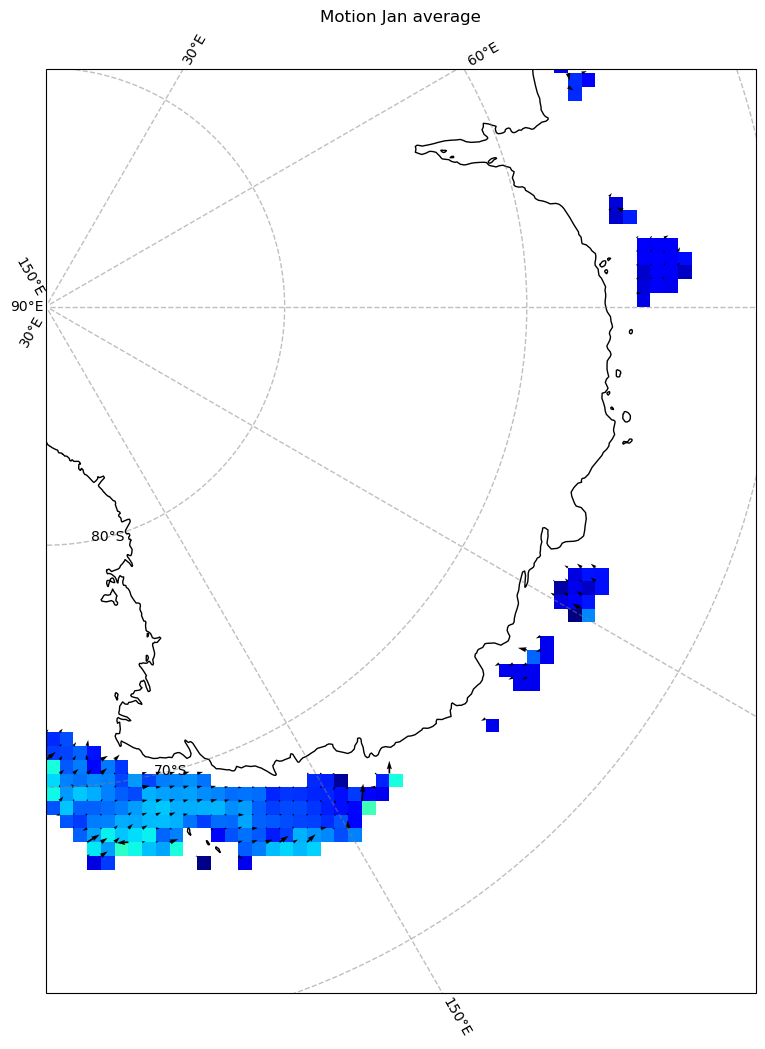

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


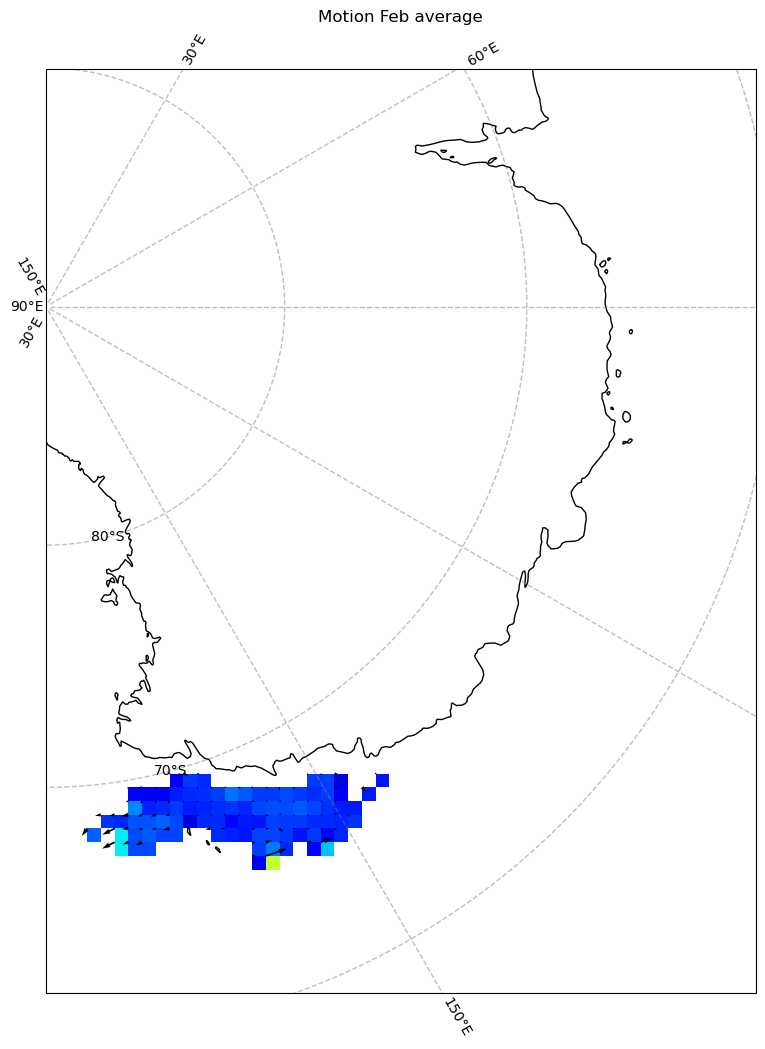

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


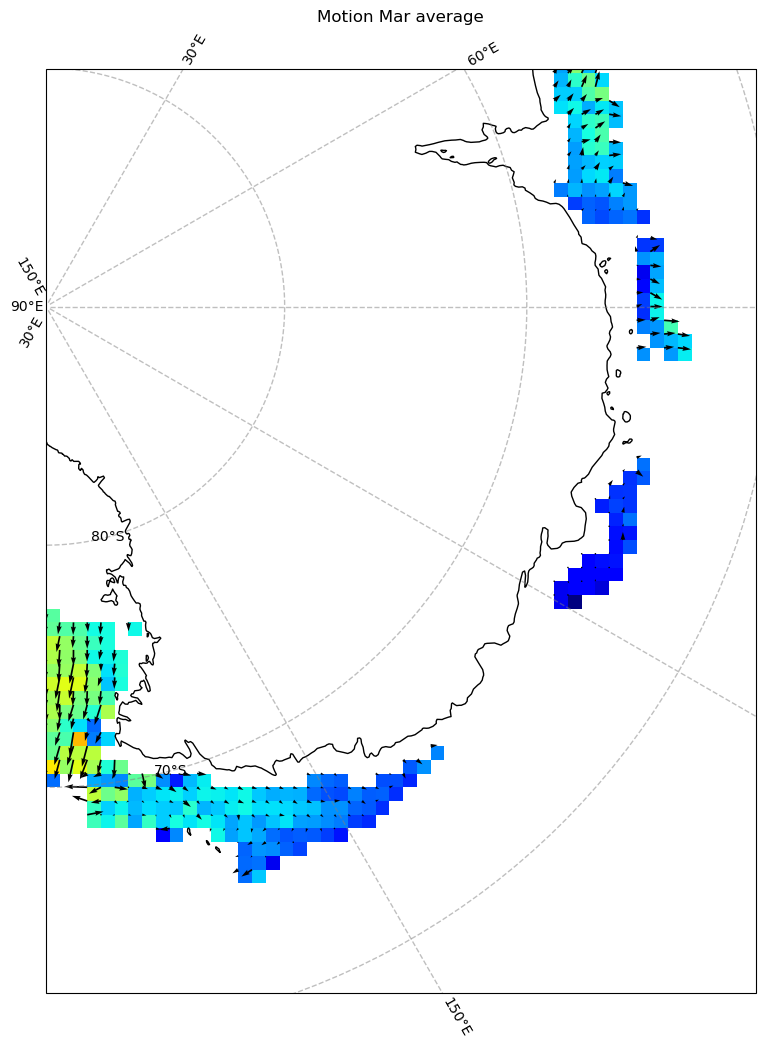

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


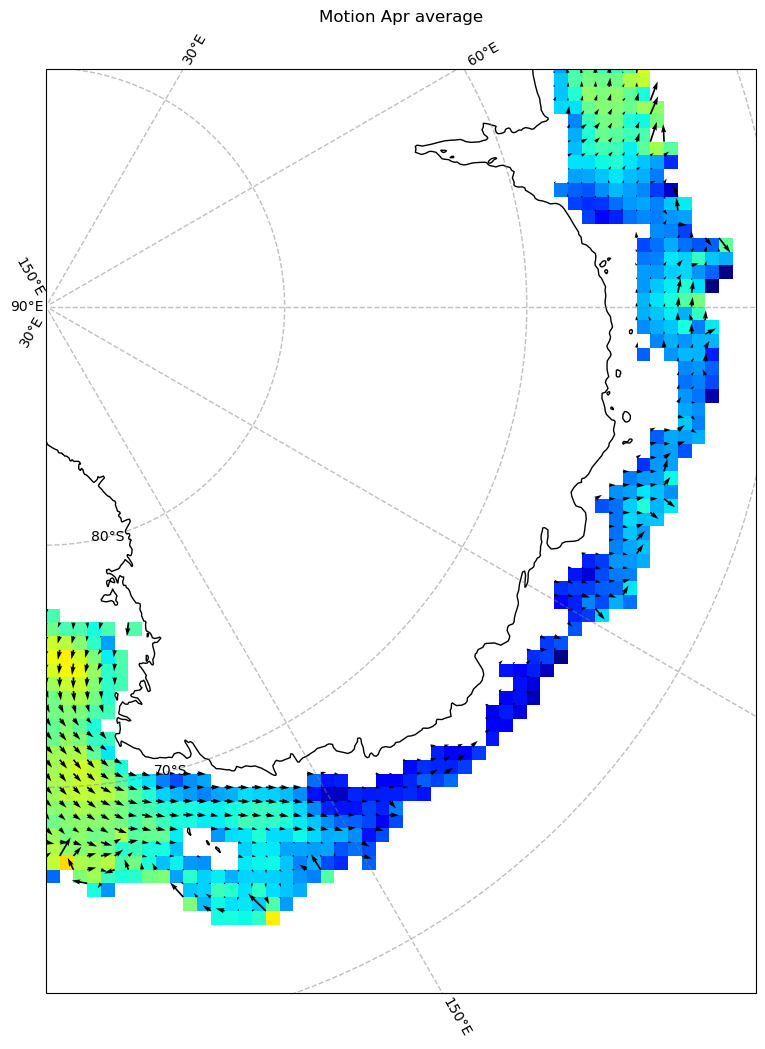

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


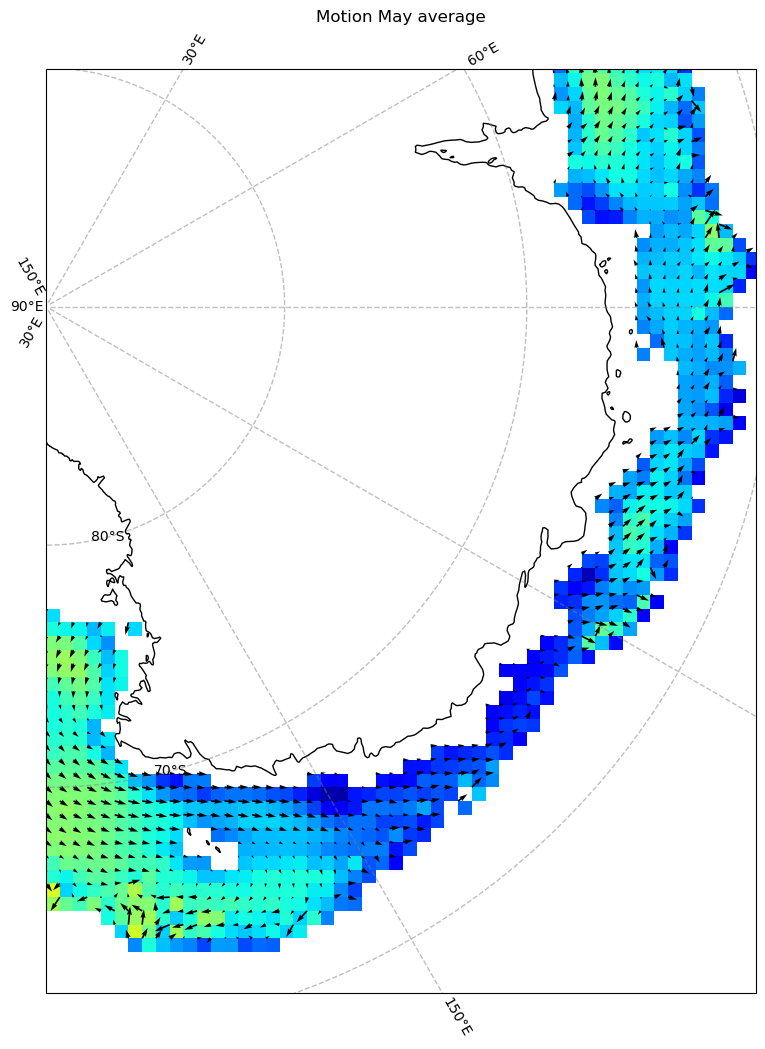

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


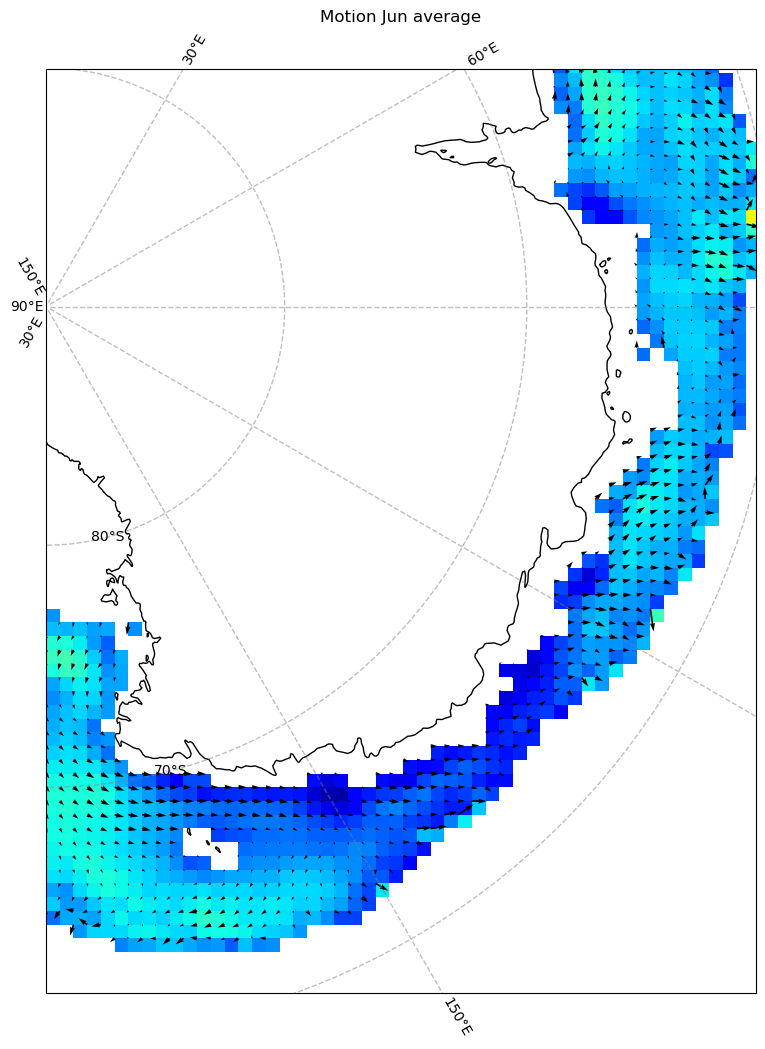

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


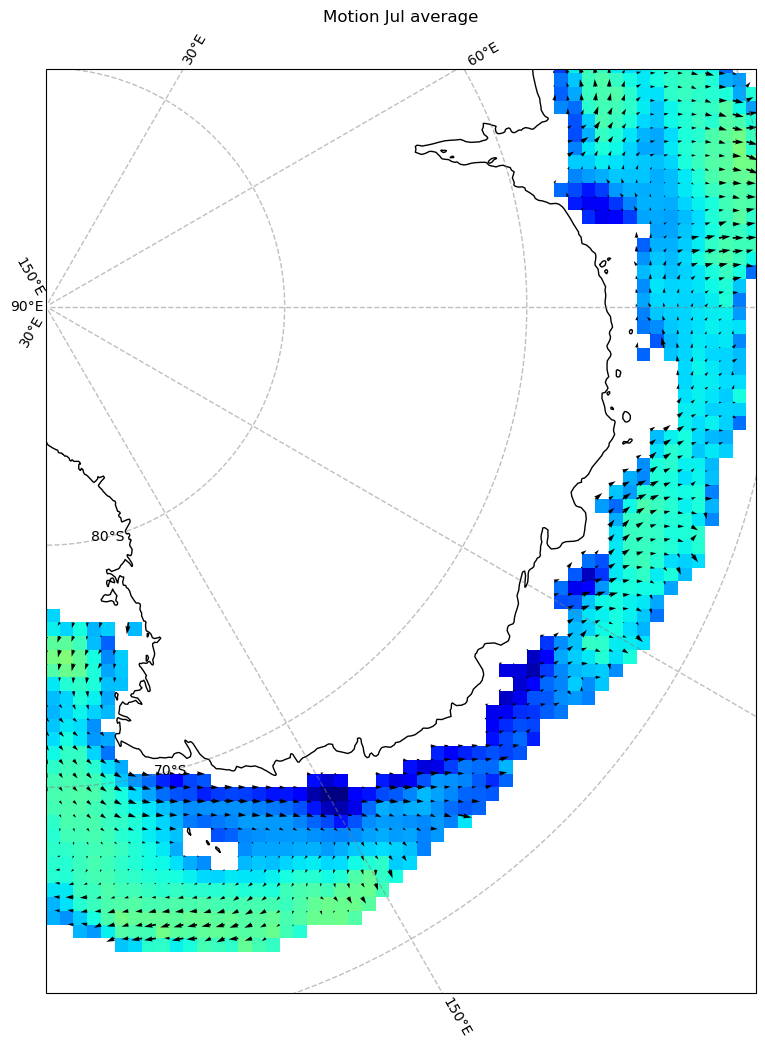

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


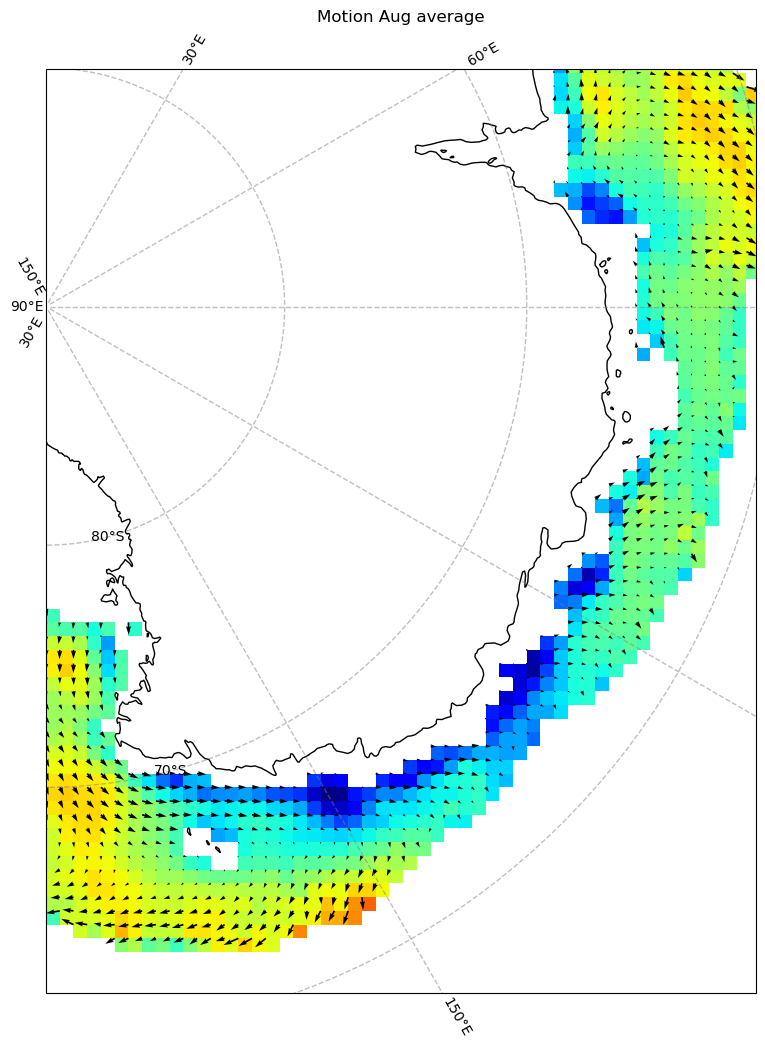

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


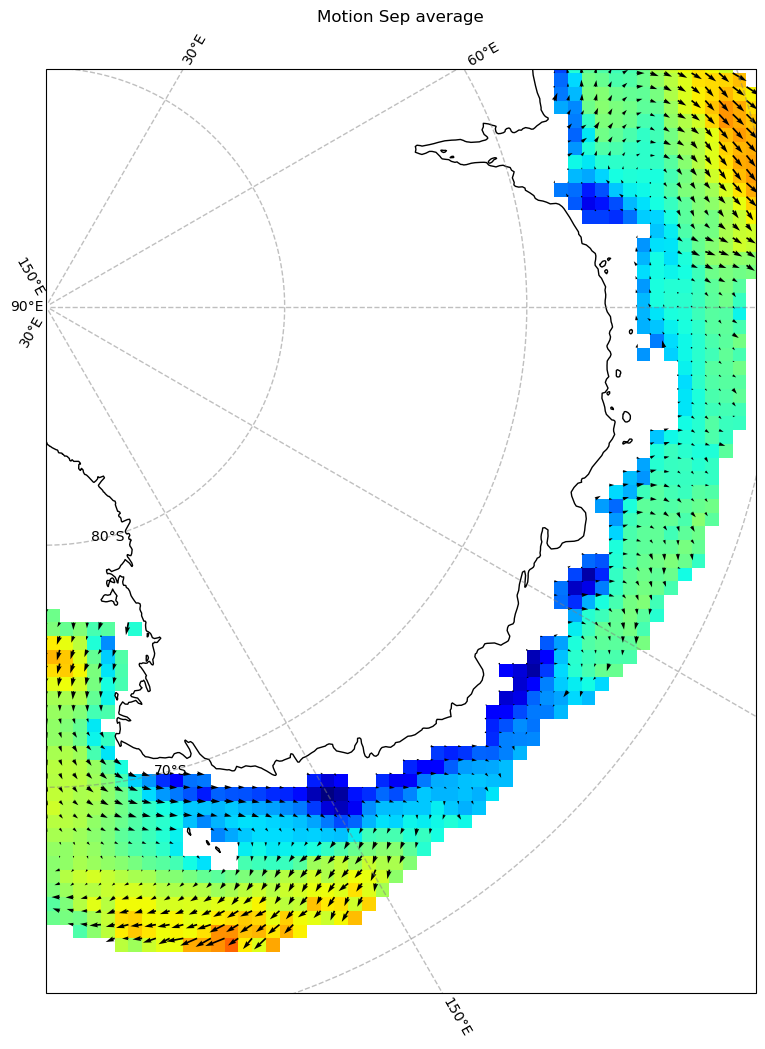

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


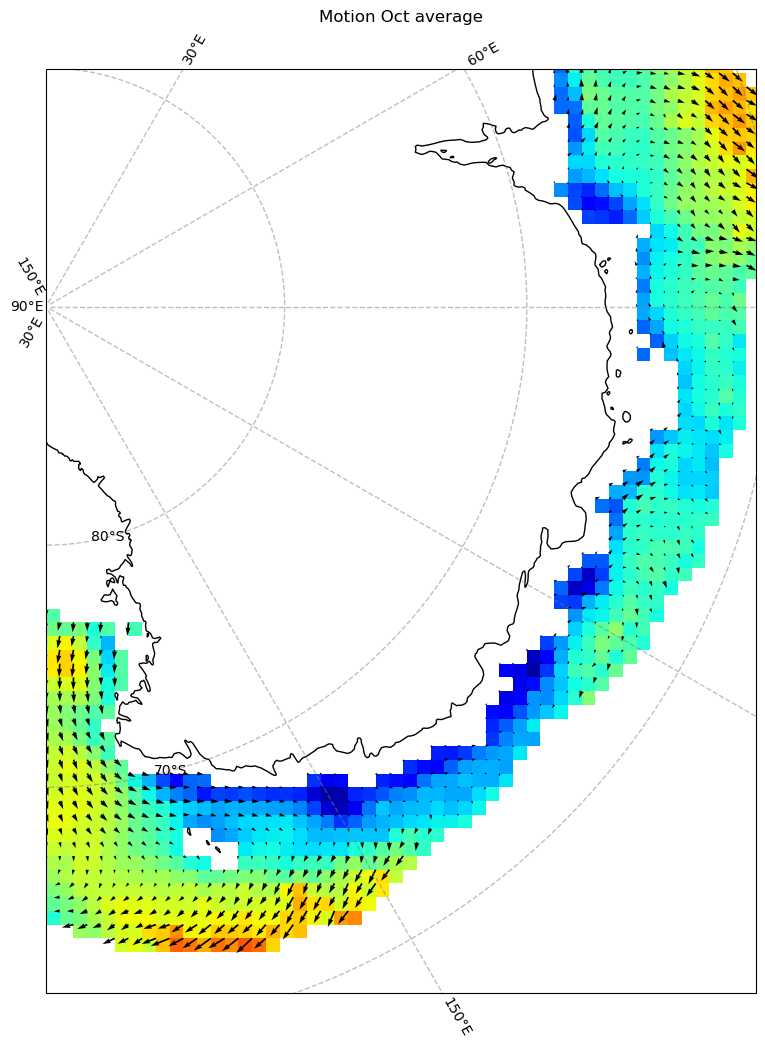

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


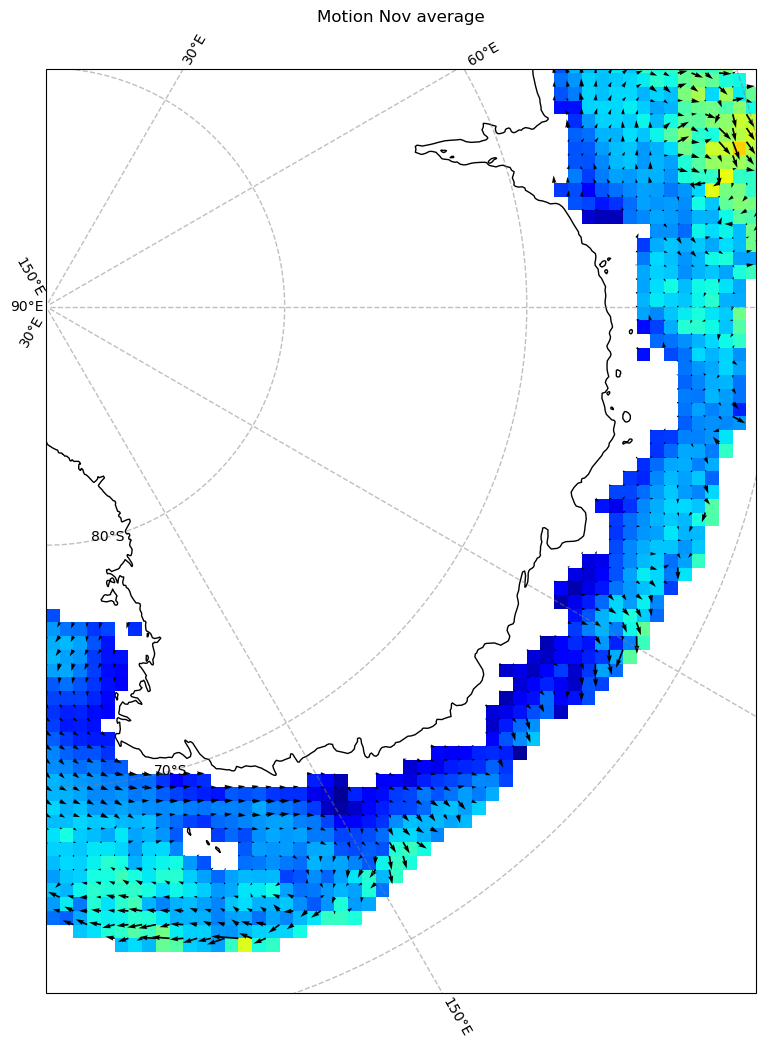

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


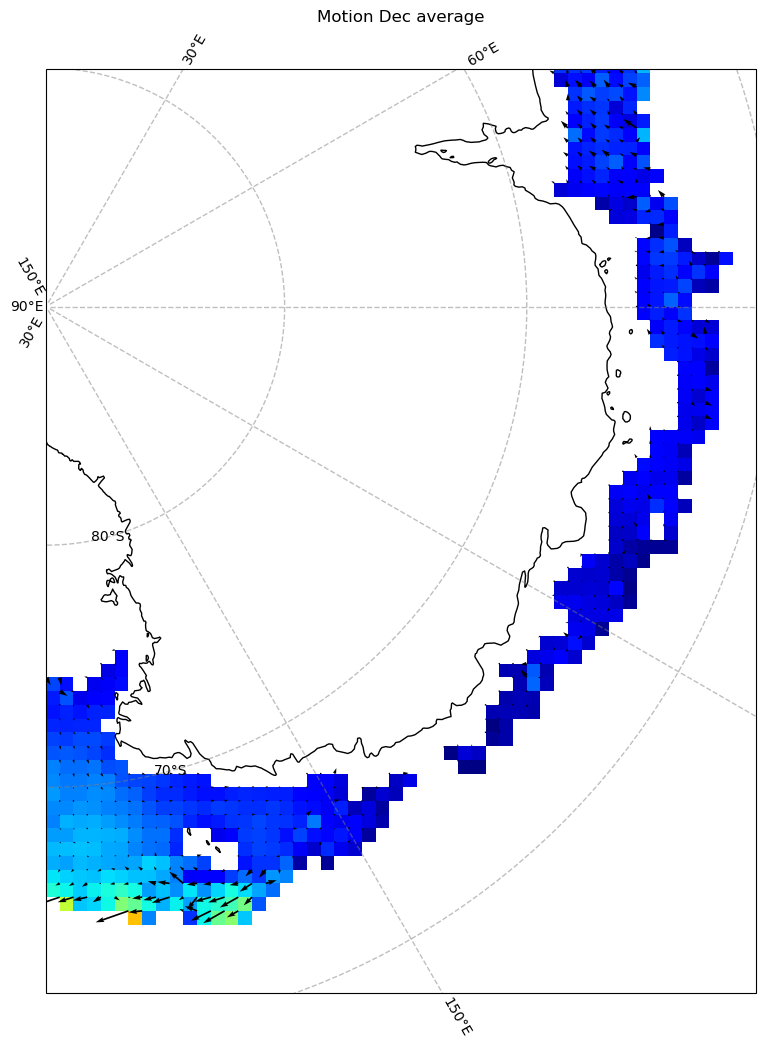

In [24]:
for MONTH in np.arange(1,13,1):

    to_plot=motion_mean_ds.sel(month=MONTH)
    
    plt.figure(figsize=(12,12))
    ax=plt.subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))

    
    plt.pcolormesh(
        to_plot.xc, 
        to_plot.yc, 
        to_plot.V_ave,
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='jet'
    )
    
    plt.quiver(
        to_plot.xc, 
        to_plot.yc, 
        to_plot.vx_ave,
        to_plot.vy_ave,
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        scale=60,
        scale_units='inches'
    )

    ax.coastlines()

    ax.set_extent(#[-180,180,#
                   [EAST_ANT_LONS[0], EAST_ANT_LONS[1], 
                  -90, -60], crs=ccrs.PlateCarree())

    add_south_pole_gridlines(ax)
    
    plt.title(f'Motion {months[MONTH-1]} average')
    
    plt.show()
    
    

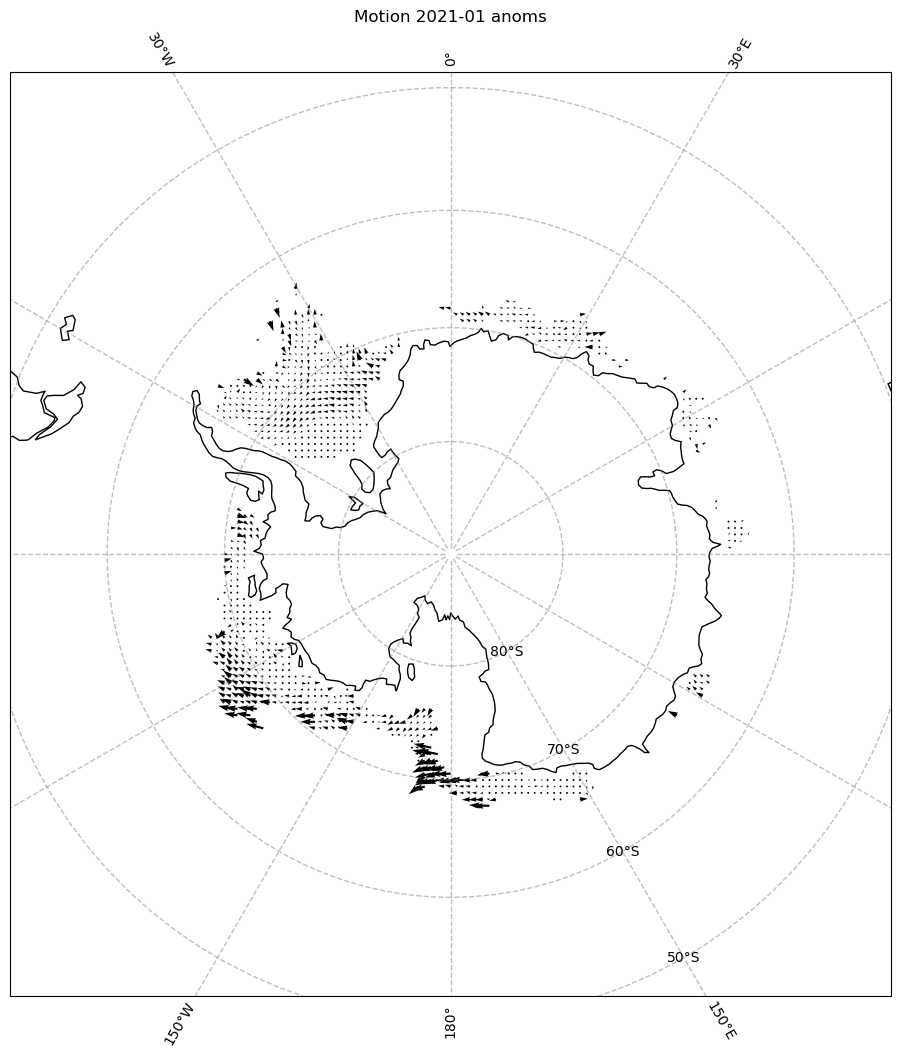

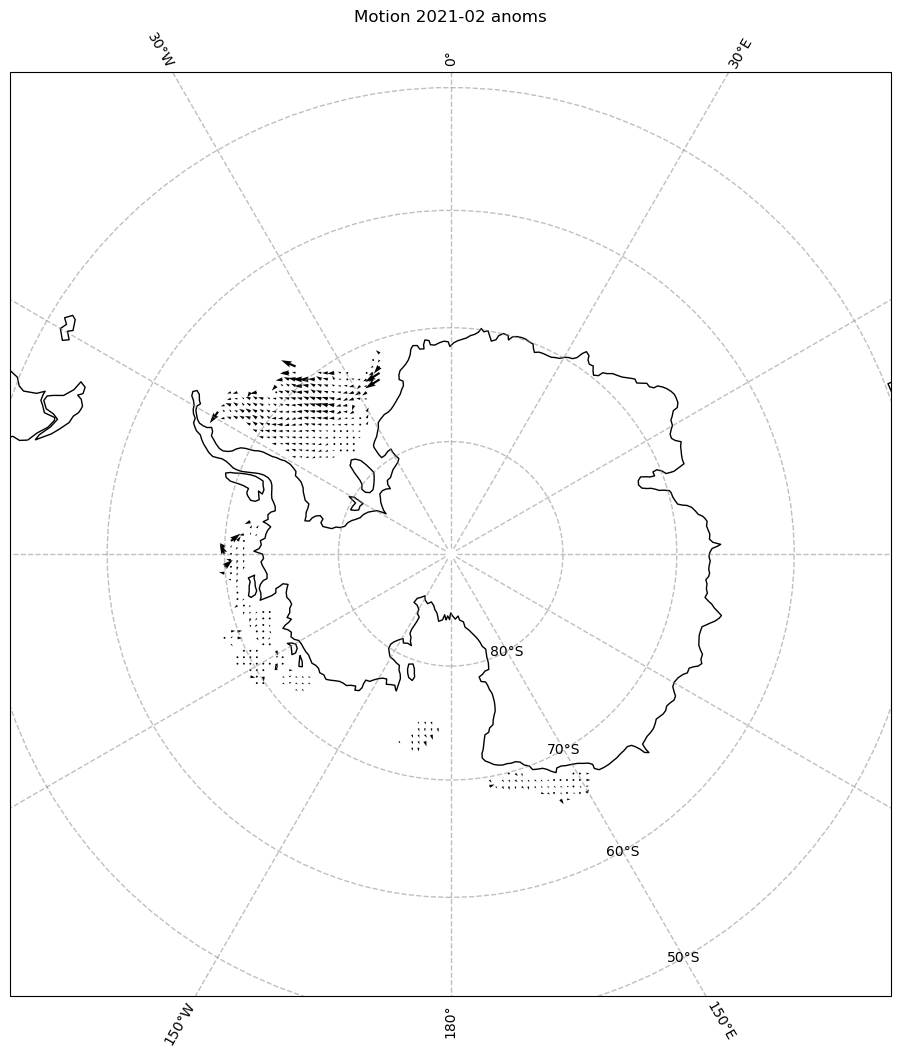

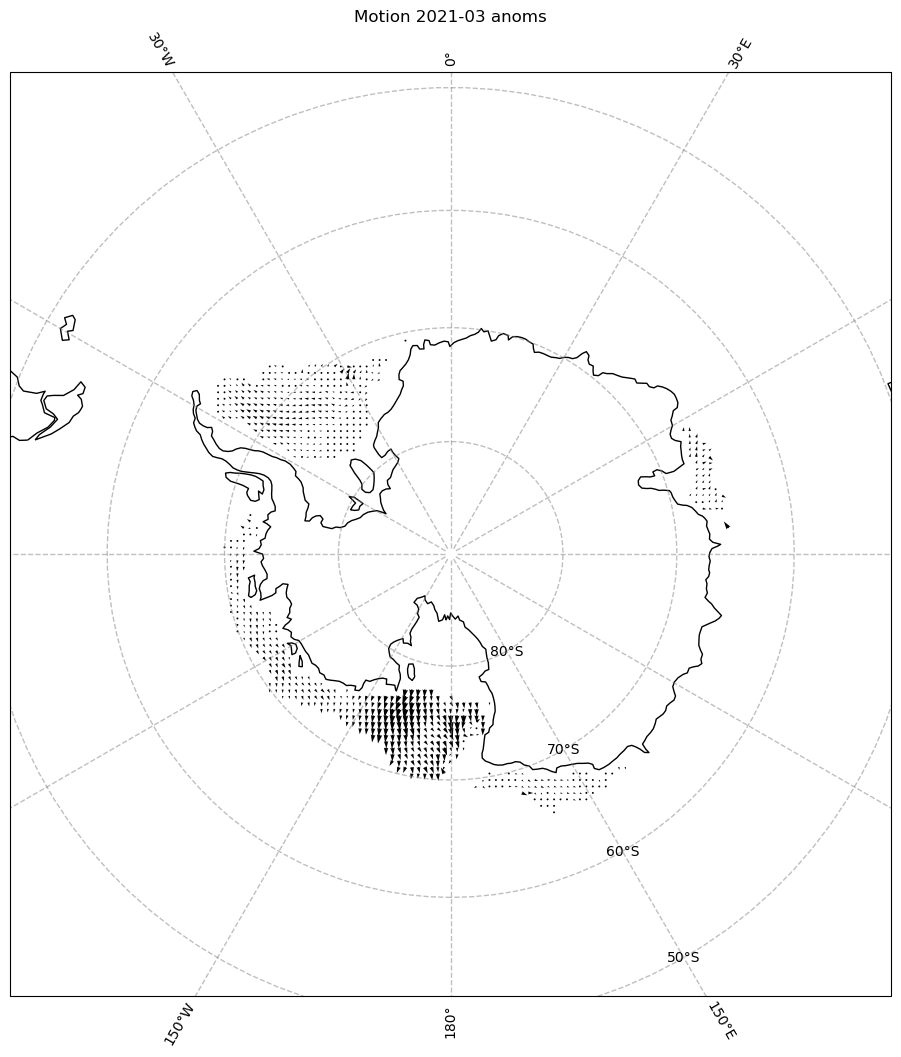

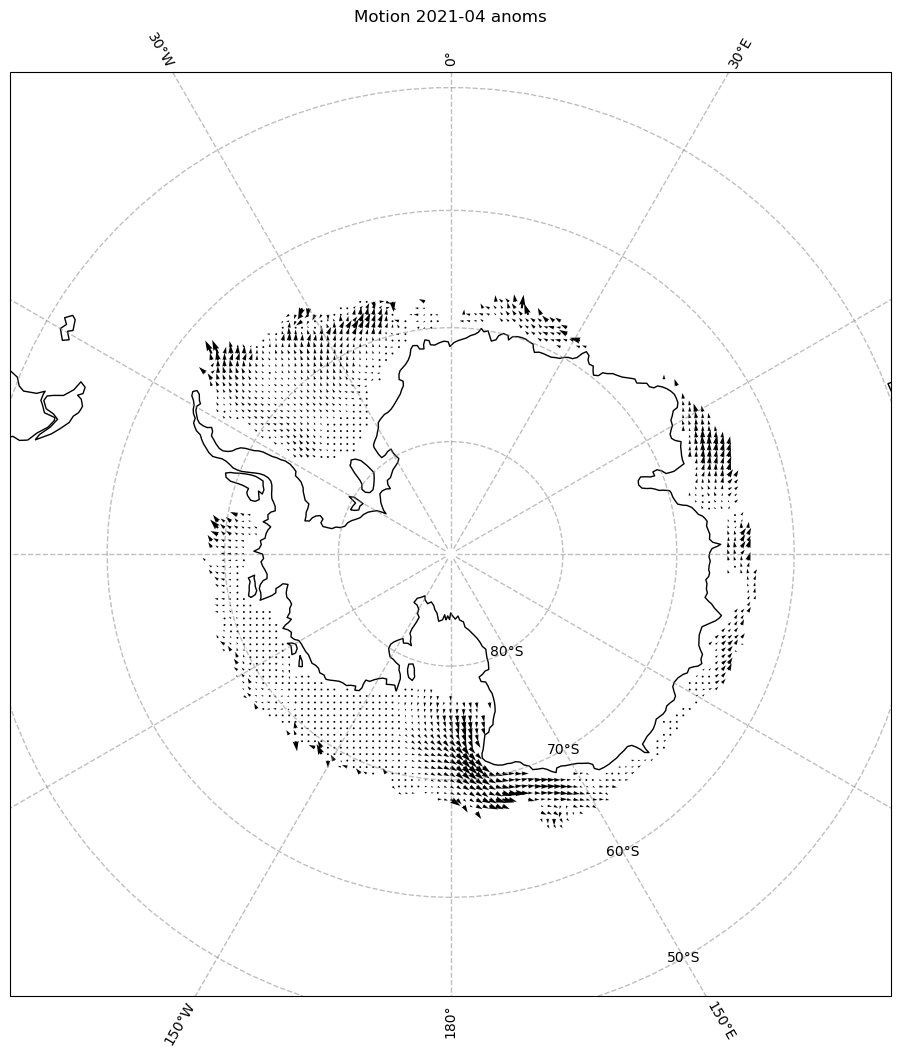

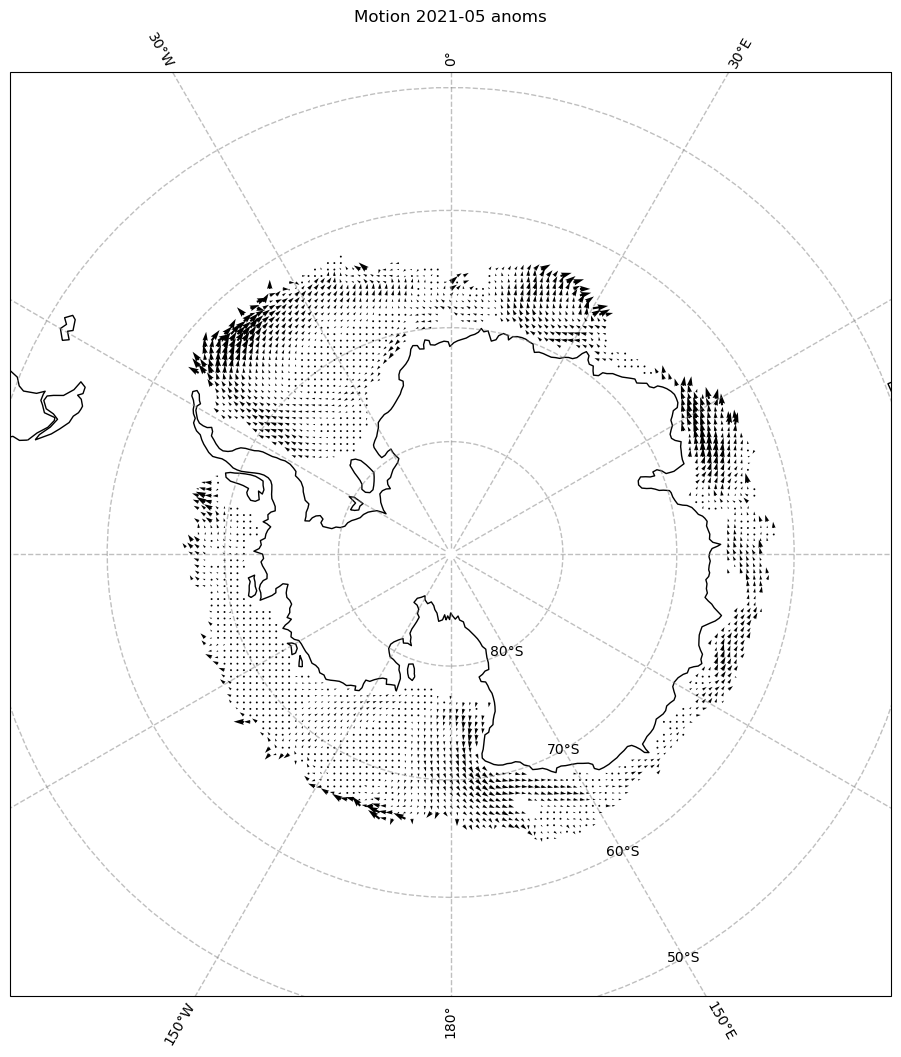

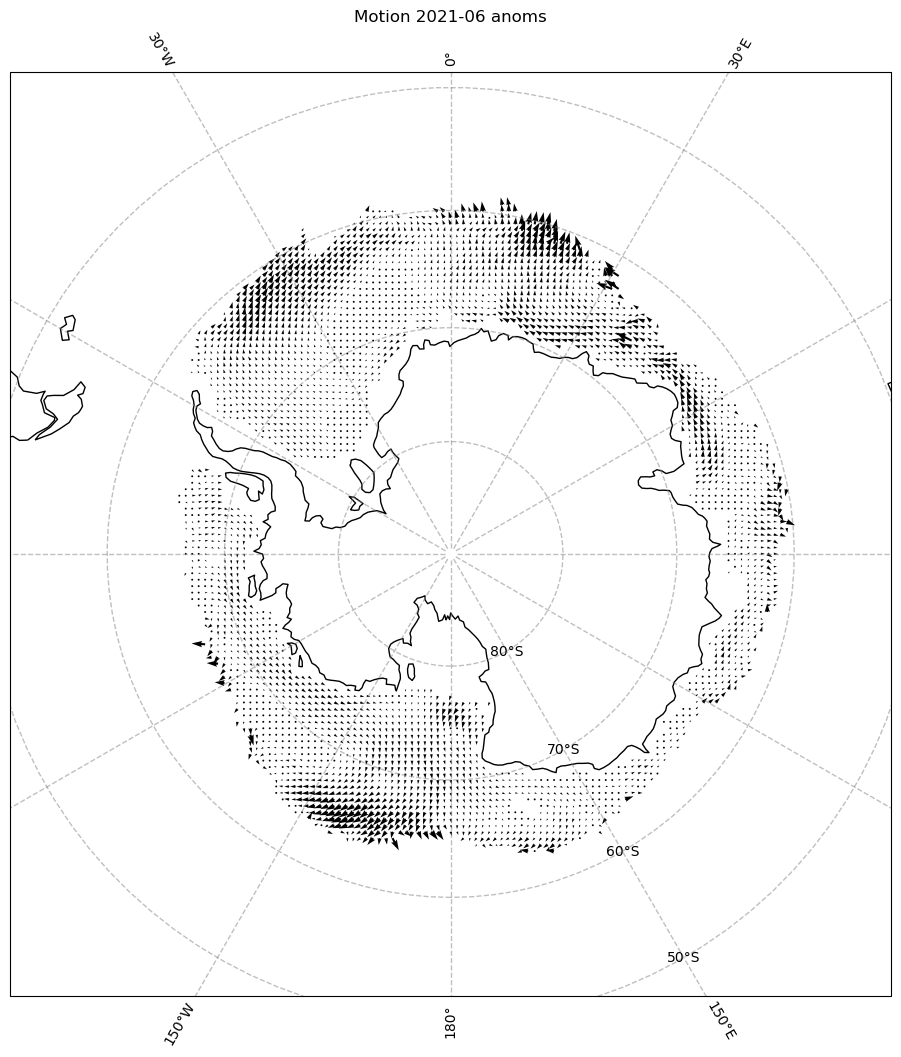

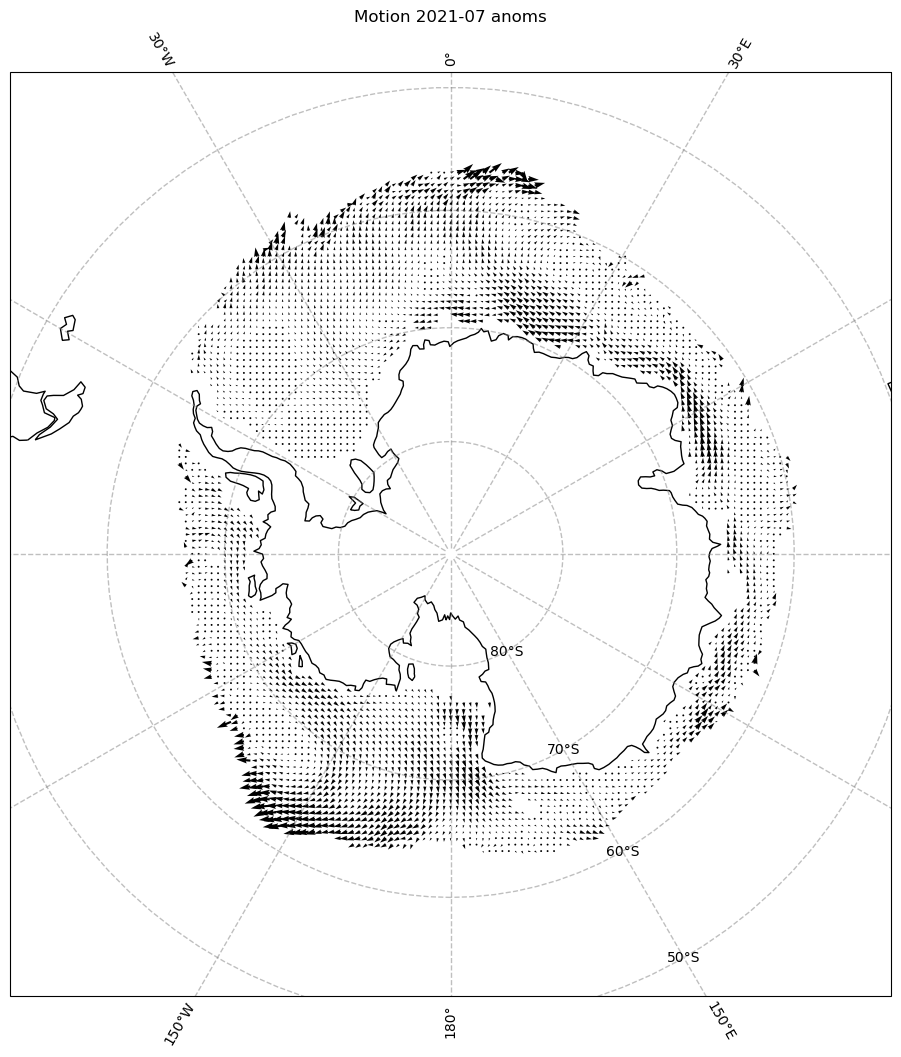

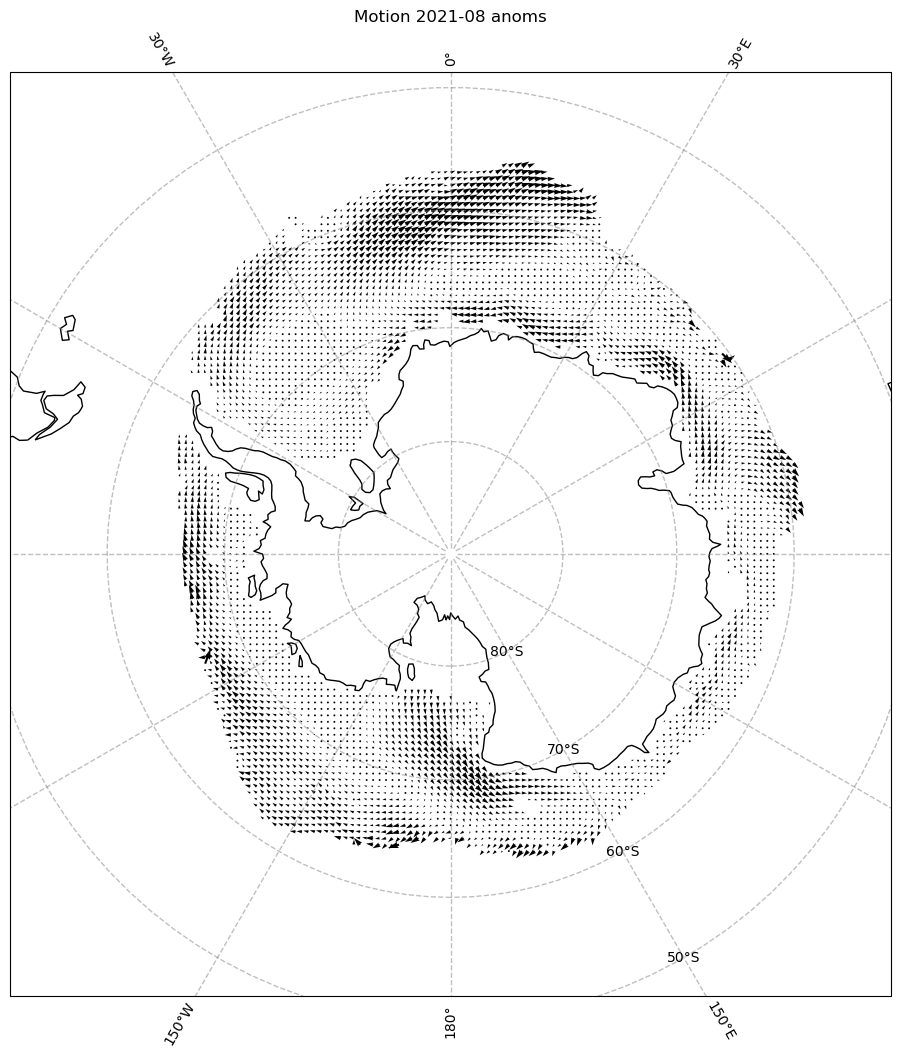

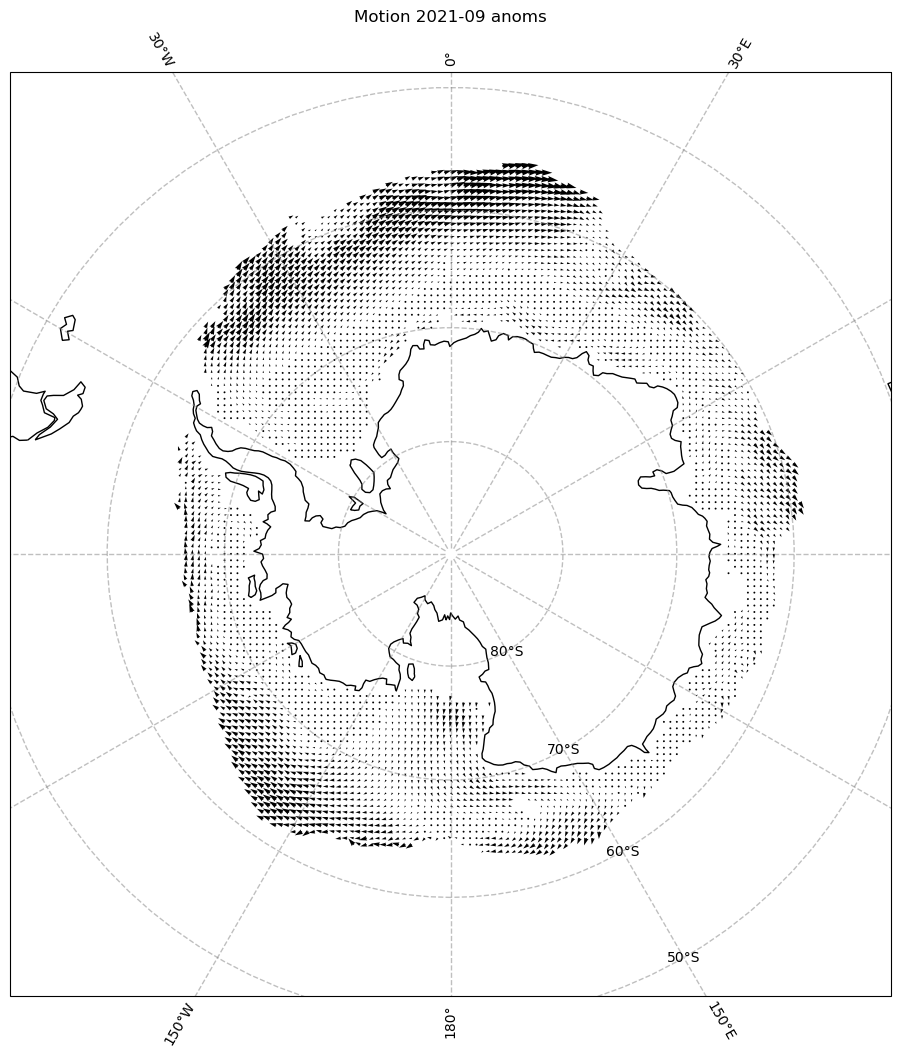

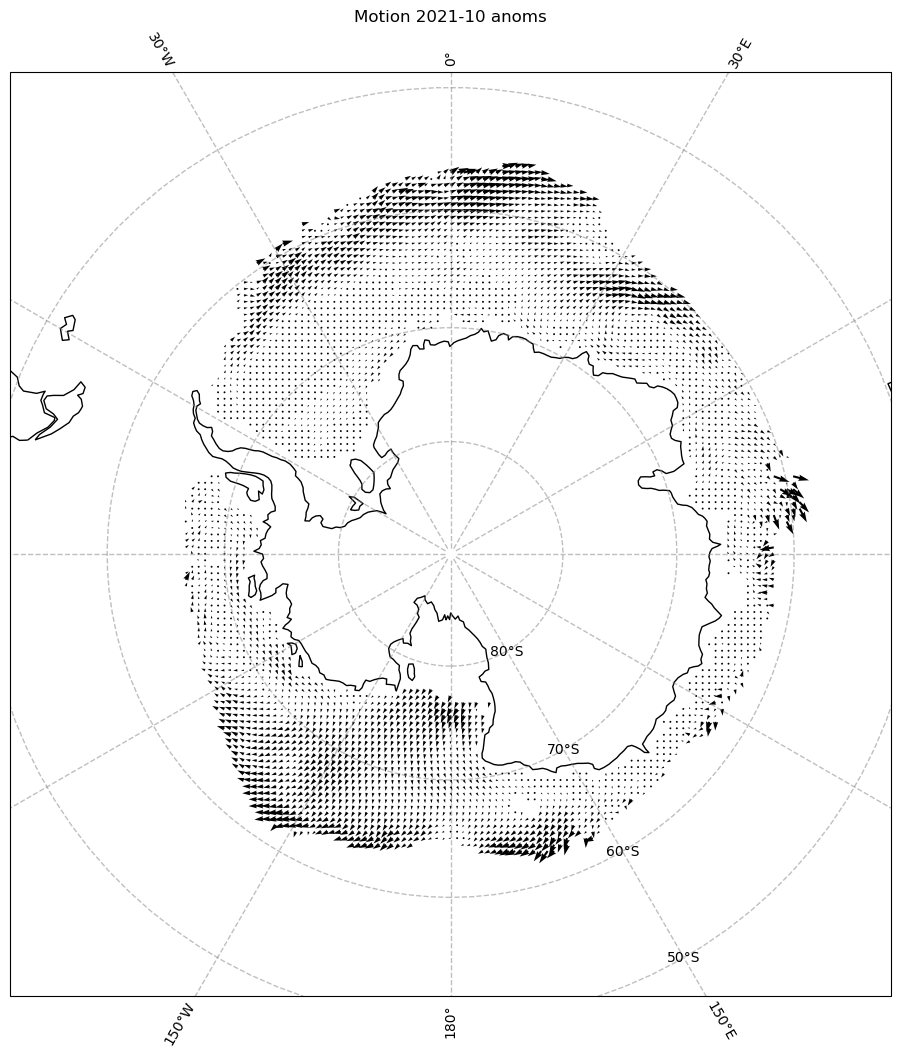

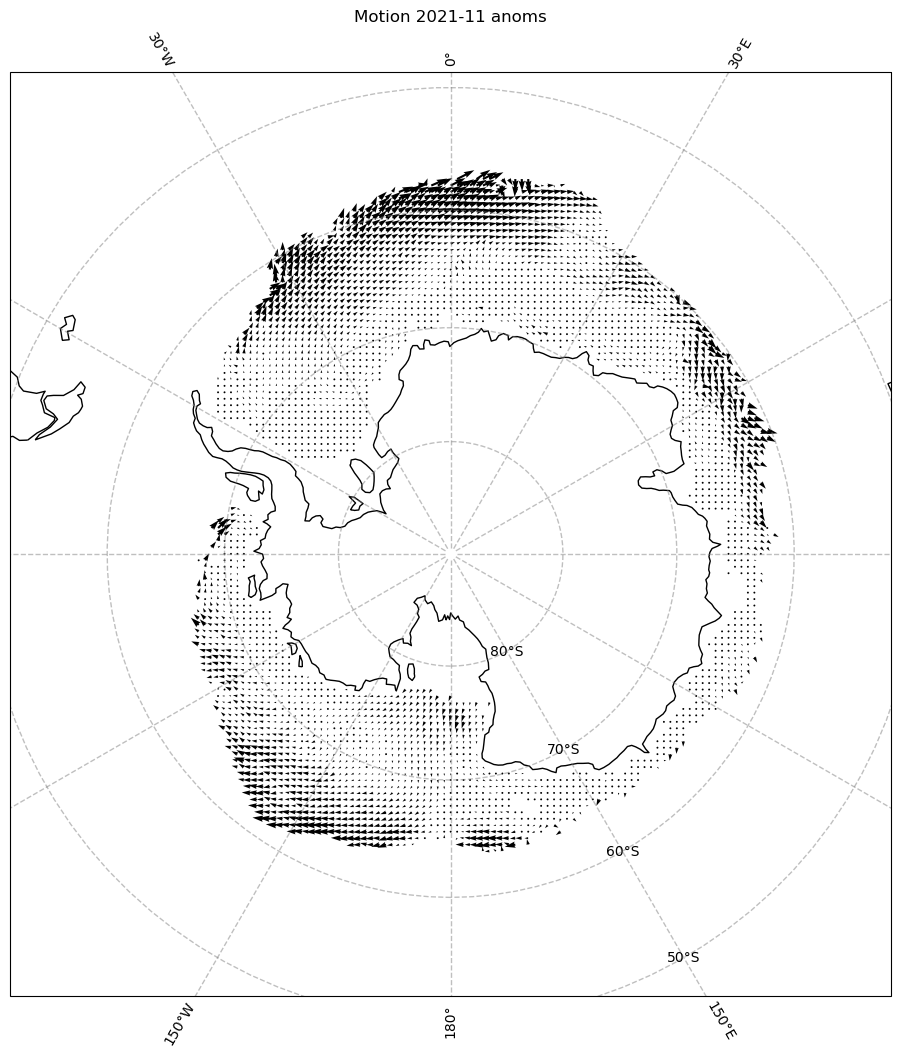

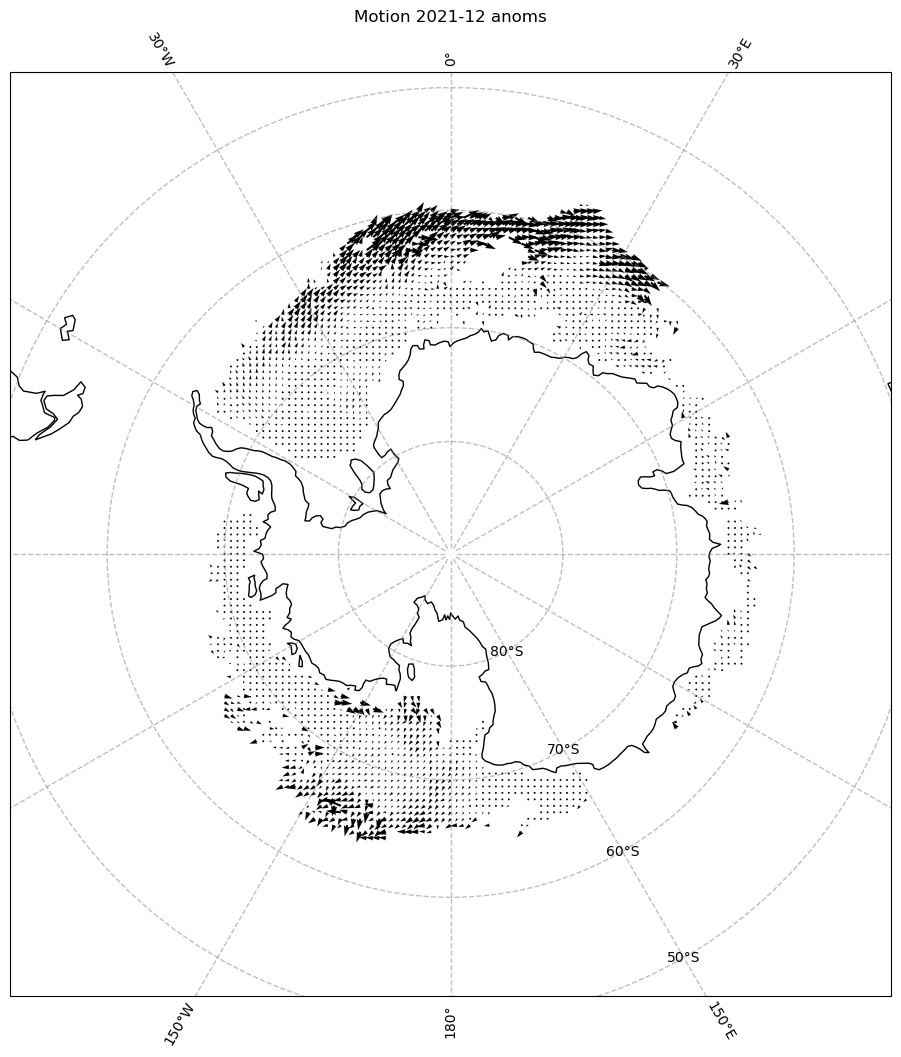

In [36]:
for month in osi_motion_monthly_ds.sel(time=slice(str(YEAR),str(YEAR))).time:

    to_plot=osi_motion_monthly_ds.sel(time=month)
    
    plt.figure(figsize=(12,12))
    ax=plt.subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))

    plt.quiver(
        (to_plot.xc), 
        (to_plot.yc), 
        to_plot.vX,
        to_plot.vY,
        # transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
    )

    ax.coastlines()

    #ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -60], crs=ccrs.PlateCarree())

    add_south_pole_gridlines(ax)
    
    plt.title( 'Motion %s' %np.datetime_as_string(month,'M'))
    
    plt.show()
    
    